In [47]:
import gymnasium as gym
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple
from torchdiffeq import odeint

# ==========================================
# 1. Physics & Environment Utilities
# ==========================================


def get_pendulum_energy(state: np.ndarray, g=10.0, m=1.0, l=1.0) -> float:
    """
    Calculates Total Energy (Hamiltonian) = Kinetic + Potential.
    Pendulum-v1 state is [cos(theta), sin(theta), theta_dot].
    Potential E = mgl(1 - cos(theta)) (0 at bottom, 2mgl at top)
    Kinetic E = 0.5 * m * (l * theta_dot)^2
    """
    # Extract cos_theta (index 0) and theta_dot (index 2)
    cos_theta = state[0]
    theta_dot = state[2]

    # Potential Energy (Reference 0 at stable equilibrium point - bottom)
    # Note: Gymnasium 0 is upright, but standard physics often puts 0 PE at bottom.
    # We use: PE = -mgl * cos(theta). Lowest point is -mgl.
    pe = -m * g * l * cos_theta

    # Kinetic Energy
    ke = 0.5 * m * (l * theta_dot) ** 2

    return pe + ke


class PendulumPhysics:
    """
    Custom pendulum physics simulator for generating ground truth trajectories
    at arbitrary time steps. Matches Gymnasium Pendulum-v1 dynamics.
    """

    def __init__(self, g=10.0, m=1.0, l=1.0, max_speed=8.0):
        self.g = g
        self.m = m
        self.l = l
        self.max_speed = max_speed

    def dynamics(self, t, state, torque):
        """
        Pendulum dynamics: d/dt[theta, theta_dot]
        Physics: I * alpha = torque - mgl*sin(theta) - damping*theta_dot
        where I = m*l^2 (moment of inertia)
        """
        theta = state[..., 0]
        theta_dot = state[..., 1]

        # Handle torque: ensure it's a tensor and can broadcast with state
        if isinstance(torque, torch.Tensor):
            # Squeeze to remove extra dimensions
            torque_val = torque.squeeze()
            # If still has dimensions, take first element or expand
            if torque_val.dim() > 0:
                if len(torque_val) > 0:
                    torque_val = torque_val[0]
                else:
                    torque_val = torque_val
        else:
            # Convert scalar to tensor on same device as state
            torque_val = torch.tensor(
                torque, device=state.device, dtype=state.dtype
            )

        # Ensure torque_val can broadcast with theta (handle batch dimension)
        if torque_val.dim() == 0:
            # Scalar tensor - will broadcast automatically
            pass
        elif torque_val.shape[0] != theta.shape[0] and theta.shape[0] > 0:
            # Expand to match batch size
            torque_val = torque_val.expand(theta.shape[0])

        # Angular acceleration
        # I * alpha = torque - mgl*sin(theta) - damping*theta_dot
        # Using standard Pendulum-v1 damping (approximate)
        damping = 0.1
        I = self.m * self.l**2

        alpha = (
            torque_val
            - self.m * self.g * self.l * torch.sin(theta)
            - damping * theta_dot
        ) / I

        # Derivatives
        dtheta_dt = theta_dot
        dtheta_dot_dt = alpha

        return torch.stack([dtheta_dt, dtheta_dot_dt], dim=-1)

    def step(self, state, action, dt):
        """
        Integrate pendulum dynamics for one time step.

        Args:
            state: [cos_theta, sin_theta, theta_dot] (Gymnasium format)
            action: Torque value (scalar or tensor)
            dt: Time step

        Returns:
            next_state: [cos_theta, sin_theta, theta_dot]
        """
        # Convert geometric state to [theta, theta_dot]
        cos_theta = state[..., 0]
        sin_theta = state[..., 1]
        theta_dot = state[..., 2]
        theta = torch.atan2(sin_theta, cos_theta)

        ode_state = torch.stack([theta, theta_dot], dim=-1)

        # Ensure action is tensor
        if isinstance(action, (int, float)):
            action = torch.tensor(
                action, device=ode_state.device, dtype=ode_state.dtype
            )
        if action.dim() == 0:
            action = action.unsqueeze(-1)

        # Define dynamics closure
        def func(t, y):
            return self.dynamics(t, y, action)

        # Integrate using ODE solver
        t_span = torch.tensor([0.0, dt], device=ode_state.device)
        next_ode_state = odeint(func, ode_state, t_span, method="dopri5")[-1]

        # Extract next state
        theta_new = next_ode_state[..., 0]
        theta_dot_new = next_ode_state[..., 1]

        # Clip velocity (Gymnasium constraint)
        theta_dot_new = torch.clamp(
            theta_dot_new, -self.max_speed, self.max_speed
        )

        # Convert back to geometric representation
        cos_theta_new = torch.cos(theta_new)
        sin_theta_new = torch.sin(theta_new)

        # Handle batch dimension
        if next_ode_state.dim() == 1:
            next_state = torch.stack(
                [cos_theta_new, sin_theta_new, theta_dot_new], dim=-1
            )
        else:
            next_state = torch.stack(
                [cos_theta_new, sin_theta_new, theta_dot_new], dim=-1
            )

        return next_state


# ==========================================
# 2. Newtonian World Model Architecture
# ==========================================


class ActionBending(nn.Module):
    """
    Your custom layer for energy/constraint management.
    Placeholder: currently passes action through, but ready for logic.
    """

    def forward(
        self, action: torch.Tensor, current_energy: torch.Tensor = None
    ) -> torch.Tensor:
        # TODO: Insert your symplectic action-bending logic here.
        # Example: Scale action if energy > limit
        return action


class NewtonianWorldModel(nn.Module):
    def __init__(self, state_dim=3, action_dim=1, hidden_dim=64):
        super().__init__()
        self.max_torque = 2.0
        self.dt = 0.05  # Standard Pendulum-v1 dt
        self.g = 10.0
        self.m = 1.0
        self.l = 1.0

        # 1. Action Bending Layer
        self.action_bender = ActionBending()

        # 2. Force Network (F = ma)
        # Input: [cos_theta, sin_theta, theta_dot] + [bent_action]
        # Output: Angular Acceleration (alpha)
        # Unlike standard NN dynamics, we ONLY predict acceleration.
        self.force_net = nn.Sequential(
            nn.Linear(state_dim + action_dim, hidden_dim),
            nn.Tanh(),  # Tanh is good for smooth physics manifolds
            nn.Linear(hidden_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, 1),  # Predicts angular acceleration directly
        )

    def ode_func(self, t, state, bent_action):
        """
        ODE function for torchdiffeq: d/dt[theta, theta_dot] = [theta_dot, alpha]
        state: [theta, theta_dot] (for ODE integration)
        Returns: [theta_dot, alpha]
        """
        # Unpack state
        theta = state[..., 0:1]
        theta_dot = state[..., 1:2]

        # Convert to geometric representation for force_net
        cos_theta = torch.cos(theta)
        sin_theta = torch.sin(theta)
        geom_state = torch.cat([cos_theta, sin_theta, theta_dot], dim=-1)

        # Predict acceleration using force network
        inputs = torch.cat([geom_state, bent_action], dim=-1)
        alpha = self.force_net(inputs)

        # Return derivatives: [dtheta/dt, dtheta_dot/dt] = [theta_dot, alpha]
        return torch.cat([theta_dot, alpha], dim=-1)

    def forward(
        self, state: torch.Tensor, action: torch.Tensor, dt: float = None
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Predicts next state using ODE integration via torchdiffeq.

        Args:
            state: Current state [cos_theta, sin_theta, theta_dot]
            action: Action (torque)
            dt: Time step for integration. If None, uses self.dt (default: 0.05)
        """
        # Use provided dt or default to self.dt
        if dt is None:
            dt = self.dt

        # A. Apply Action Bending
        bent_action = self.action_bender(action)

        # B. Convert geometric state [cos_theta, sin_theta, theta_dot] to [theta, theta_dot]
        cos_th = state[:, 0:1]
        sin_th = state[:, 1:2]
        th_dot = state[:, 2:3]
        theta = torch.atan2(sin_th, cos_th)
        ode_state = torch.cat([theta, th_dot], dim=-1)

        # C. Define ODE function closure for torchdiffeq
        def func(t, y):
            return self.ode_func(t, y, bent_action)

        # D. Integrate using ODE solver
        t_span = torch.tensor([0.0, dt], device=state.device)
        next_ode_state = odeint(func, ode_state, t_span, method="rk4")[-1]

        # E. Extract next theta and theta_dot
        theta_new = next_ode_state[:, 0:1]
        th_dot_new = next_ode_state[:, 1:2]

        # F. Clip velocity (Gymnasium physics constraint)
        th_dot_new = torch.clamp(th_dot_new, -8.0, 8.0)

        # G. Re-encode geometric state
        new_cos = torch.cos(theta_new)
        new_sin = torch.sin(theta_new)
        next_state_pred = torch.cat([new_cos, new_sin, th_dot_new], dim=-1)

        # H. Get predicted acceleration for return value
        geom_state_new = torch.cat([new_cos, new_sin, th_dot_new], dim=-1)
        inputs_new = torch.cat([geom_state_new, bent_action], dim=-1)
        pred_alpha = self.force_net(inputs_new)

        return next_state_pred, pred_alpha


# ==========================================
# 2b. Baseline Models (MLP, LSTM, First-Order ODE)
# ==========================================


class JumpModel(nn.Module):
    """
    Baseline MLP: Learns state_{t+1} = state_t + f(state_t, action_t)
    Approximates dynamics as a discrete map (ResNet-style).
    """

    def __init__(self, state_dim=3, action_dim=1, hidden_dim=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim + action_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, state_dim),  # Outputs Delta State
        )

    def forward(self, state, action):
        # Ensure action has correct shape
        if action.dim() == 1:
            action = action.unsqueeze(-1)
        delta = self.net(torch.cat([state, action], dim=-1))
        return state + delta


class LSTMModel(nn.Module):
    """
    LSTM baseline: Uses sequence history to predict next state.
    """

    def __init__(self, state_dim=3, action_dim=1, hidden_dim=64):
        super().__init__()
        self.lstm = nn.LSTM(
            state_dim + action_dim, hidden_dim, batch_first=True
        )
        self.fc = nn.Linear(hidden_dim, state_dim)

    def forward(self, state, action):
        # state: [B, T, 3] or [B, 3]
        # action: [B, T, 1] or [B, 1]

        # Handle single timestep case
        if state.dim() == 2:
            state = state.unsqueeze(1)  # [B, 1, 3]
        if action.dim() == 2:
            action = action.unsqueeze(1)  # [B, 1, 1]

        # Concatenate state and action
        x = torch.cat([state, action], dim=-1)  # [B, T, 4]
        x, _ = self.lstm(x)
        delta = self.fc(x)

        # Return state + delta (ResNet connection)
        return state + delta


class FirstOrderODENet(nn.Module):
    """
    Pure Neural ODE: Learns d/dt[state] = f(state, action)
    Neural network predicts the full state derivative directly.
    """

    def __init__(self, state_dim=3, action_dim=1, hidden_dim=64):
        super().__init__()
        self.dt = 0.05

        # Neural network predicts full state derivative: d/dt[cos_theta, sin_theta, theta_dot]
        self.net = nn.Sequential(
            nn.Linear(state_dim + action_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(
                hidden_dim, state_dim
            ),  # Output: [dcos/dt, dsin/dt, dtheta_dot/dt]
        )

    def forward(self, t, state, action):
        """
        ODE function: d/dt[state] = f(state, action)
        state: [cos_theta, sin_theta, theta_dot] or [B, 3]
        action: [torque] or [B, 1]
        Returns: [dcos/dt, dsin/dt, dtheta_dot/dt] or [B, 3]
        """
        # Ensure action has correct shape to match state batch dimension
        if action.dim() == 1:
            action = action.unsqueeze(-1)
        elif action.dim() == 2 and action.shape[1] != 1:
            action = action.unsqueeze(-1) if action.shape[-1] == 1 else action

        # Handle batch dimension matching
        if state.dim() == 2 and action.dim() == 2:
            # Both have batch dimension, ensure they match
            if state.shape[0] != action.shape[0]:
                action = action[0:1].expand(state.shape[0], -1)
        elif state.dim() == 1 and action.dim() == 2:
            # state is [3], action is [B, 1] -> squeeze action
            action = action.squeeze(0)
        elif state.dim() == 2 and action.dim() == 1:
            # state is [B, 3], action is [1] -> expand action
            action = action.unsqueeze(0).expand(state.shape[0], -1)

        # Concatenate state and action
        inputs = torch.cat([state, action], dim=-1)
        state_derivative = self.net(inputs)

        return state_derivative


class FirstOrderTrajectoryModel(nn.Module):
    """
    Wrapper for pure Neural ODE model.
    Simply integrates the neural network ODE function.
    """

    def __init__(self, ode_func):
        super().__init__()
        self.ode_func = ode_func
        self.dt = 0.05

    def forward(self, state, action, dt=0.05):
        """
        Integrates one step forward using ODE solver.
        state: [B, 3] - [cos_theta, sin_theta, theta_dot]
        action: [B, 1] - torque
        Returns: [B, 3] - next state
        """
        # Ensure action has correct shape
        if action.dim() == 1:
            action = action.unsqueeze(-1)
        elif action.dim() == 2 and action.shape[1] != 1:
            action = action.unsqueeze(-1) if action.shape[-1] == 1 else action

        # Define dynamics closure for torchdiffeq
        def func(t, y):
            return self.ode_func(t, y, action)

        # Integrate from t=0 to t=dt
        # This integrates d/dt[state] = f(state, action) to get next state
        t_span = torch.tensor([0.0, dt], device=state.device)
        next_state = odeint(func, state, t_span, method="rk4")[-1]

        # Clip velocity (Gymnasium physics constraint) - avoid in-place operation
        next_state = torch.cat(
            [next_state[:, 0:2], torch.clamp(next_state[:, 2:3], -8.0, 8.0)],
            dim=-1,
        )

        return next_state


# ==========================================
# 3. Test Harness
# ==========================================


def evaluate_model(env_name, model, horizon=200):
    """
    Compares Model (Open-Loop) vs Real Environment (Ground Truth).
    "Open-Loop" means we feed the model's OWN prediction back into itself
    to test drift/hallucination over time.
    """
    env = gym.make(env_name)
    obs, _ = env.reset(seed=42)

    # Storage
    real_states = []
    pred_states = []
    real_energies = []
    pred_energies = []

    # Initialize Model State
    current_pred_state = torch.tensor(obs, dtype=torch.float32).unsqueeze(0)

    # Run Episode
    for t in range(horizon):
        # 1. Select Action (Random policy for stress testing dynamics)
        action = env.action_space.sample()
        action_tensor = torch.tensor(action, dtype=torch.float32).unsqueeze(0)

        # 2. Ground Truth Step
        next_obs, reward, terminated, truncated, _ = env.step(action)
        real_states.append(obs)
        real_energies.append(get_pendulum_energy(obs))

        # 3. Model Prediction Step (Open-Loop Recursive)
        with torch.no_grad():
            next_pred_state, _ = model(current_pred_state, action_tensor)

        # Store prediction
        pred_np = current_pred_state.squeeze().numpy()
        pred_states.append(pred_np)
        pred_energies.append(get_pendulum_energy(pred_np))

        # Update loop variables
        obs = next_obs
        current_pred_state = next_pred_state  # Feed self-prediction back in

        if terminated or truncated:
            break

    return (
        np.array(real_states),
        np.array(pred_states),
        np.array(real_energies),
        np.array(pred_energies),
    )


# ==========================================
# 4. Main Execution & Plotting
# ==========================================

Testing NWM on Pendulum-v1...


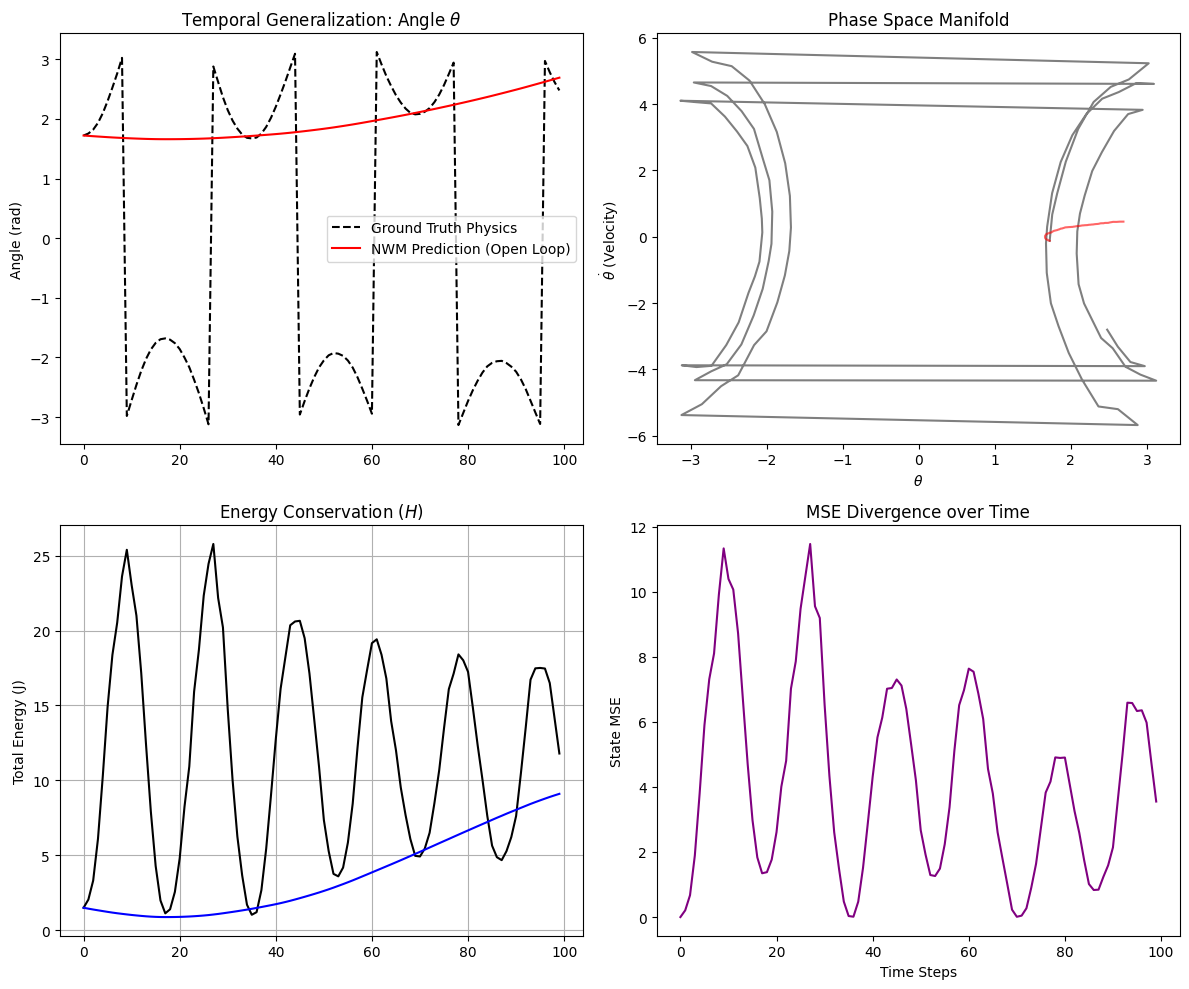

Done. If NWM is untrained, expect random divergence (Red line).
If 'Energy' (Blue) stays constant while MSE rises, you have proved stability!


In [42]:
# 1. Setup
env_name = "Pendulum-v1"
model = NewtonianWorldModel()
# NOTE: Model is untrained. In real exp, load_state_dict(torch.load("nwm.pth"))

print(f"Testing NWM on {env_name}...")

# 2. Run Evaluation
real_s, pred_s, real_e, pred_e = evaluate_model(env_name, model, horizon=100)

# 3. Visualization
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Plot A: Angle (Theta) over Time
# Convert sin/cos to angle for cleaner plotting
real_theta = np.arctan2(real_s[:, 1], real_s[:, 0])
pred_theta = np.arctan2(pred_s[:, 1], pred_s[:, 0])

axs[0, 0].plot(
    real_theta, label="Ground Truth Physics", color="black", linestyle="--"
)
axs[0, 0].plot(pred_theta, label="NWM Prediction (Open Loop)", color="red")
axs[0, 0].set_title("Temporal Generalization: Angle $\\theta$")
axs[0, 0].set_ylabel("Angle (rad)")
axs[0, 0].legend()

# Plot B: Phase Space (Theta vs Theta_dot)
axs[0, 1].plot(
    real_theta, real_s[:, 2], label="Real", color="black", alpha=0.5
)
axs[0, 1].plot(pred_theta, pred_s[:, 2], label="NWM", color="red", alpha=0.6)
axs[0, 1].set_title("Phase Space Manifold")
axs[0, 1].set_xlabel("$\\theta$")
axs[0, 1].set_ylabel("$\\dot{\\theta}$ (Velocity)")

# Plot C: Energy Conservation (The "Aristotelian Collapse" check)
axs[1, 0].plot(real_e, label="Real Energy", color="black")
axs[1, 0].plot(pred_e, label="NWM Energy", color="blue")
axs[1, 0].set_title("Energy Conservation ($H$)")
axs[1, 0].set_ylabel("Total Energy (J)")
axs[1, 0].grid(True)

# Plot D: Error Accumulation
mse = np.mean((real_s - pred_s) ** 2, axis=1)
axs[1, 1].plot(mse, color="purple")
axs[1, 1].set_title("MSE Divergence over Time")
axs[1, 1].set_xlabel("Time Steps")
axs[1, 1].set_ylabel("State MSE")

plt.tight_layout()
plt.show()

print("Done. If NWM is untrained, expect random divergence (Red line).")
print(
    "If 'Energy' (Blue) stays constant while MSE rises, you have proved stability!"
)

In [43]:
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
from tqdm import tqdm


class PendulumDataset(Dataset):
    """
    Collects sequences of (state, action, next_state) from Pendulum-v1 environment.
    """

    def __init__(
        self,
        n_seqs=500,
        seq_len=50,
        env_name="Pendulum-v1",
        seed=42,
    ):
        self.data = []
        env = gym.make(env_name)

        print(f"Generating {n_seqs} sequences of length {seq_len}...")

        for seq_idx in range(n_seqs):
            obs, _ = env.reset(seed=seed + seq_idx)

            states = [obs]
            actions = []

            # Generate sequence
            for _ in range(seq_len):
                # Random action (continuous torque in [-2, 2])
                action = env.action_space.sample()
                next_obs, reward, terminated, truncated, _ = env.step(action)

                states.append(next_obs)
                actions.append(action)
                obs = next_obs

                if terminated or truncated:
                    break

            # Store transitions: (state, action, next_state)
            for i in range(len(states) - 1):
                self.data.append(
                    {
                        "state": torch.tensor(states[i], dtype=torch.float32),
                        "action": torch.tensor(
                            actions[i], dtype=torch.float32
                        ),
                        "next_state": torch.tensor(
                            states[i + 1], dtype=torch.float32
                        ),
                    }
                )

        env.close()
        print(f"Collected {len(self.data)} transitions")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]


# ==========================================
# 4. Training Loop
# ==========================================


def train_model(
    dataset,
    model,
    epochs=50,
    batch_size=64,
    lr=1e-3,
    train_split=0.8,
    verbose=True,
):
    """
    Trains the NewtonianWorldModel on collected pendulum data.
    """
    # Split dataset
    len_dataset = len(dataset)
    perm = np.random.permutation(len_dataset)
    train_indices = perm[: int(len_dataset * train_split)]
    test_indices = perm[int(len_dataset * train_split) :]

    train_dataset = [dataset[i] for i in train_indices]
    test_dataset = [dataset[i] for i in test_indices]

    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True
    )
    test_loader = DataLoader(
        test_dataset, batch_size=batch_size, shuffle=False
    )

    # Optimizer
    optimizer = optim.Adam(model.parameters(), lr=lr)

    def train_step(batch):
        states = batch["state"]
        actions = batch["action"]
        targets = batch["next_state"]

        # Forward pass
        pred_next_state, pred_alpha = model(states, actions)

        # MSE loss on state prediction
        loss = ((pred_next_state - targets) ** 2).mean()

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        return loss.item()

    @torch.no_grad()
    def test_step(batch):
        states = batch["state"]
        actions = batch["action"]
        targets = batch["next_state"]

        pred_next_state, pred_alpha = model(states, actions)
        loss = ((pred_next_state - targets) ** 2).mean()

        return loss.item()

    # Training loop
    print("Training NewtonianWorldModel...")
    pbar = tqdm(
        range(1, epochs + 1),
        desc=f"Epoch {1} | Train Loss: 0.0000 | Test Loss: 0.0000",
    )

    best_test_loss = float("inf")

    for epoch in range(1, epochs + 1):
        # Training
        model.train()
        total_train_loss = 0.0
        for batch in train_loader:
            loss = train_step(batch)
            total_train_loss += loss

        avg_train_loss = total_train_loss / len(train_loader)

        # Testing
        model.eval()
        total_test_loss = 0.0
        for batch in test_loader:
            loss = test_step(batch)
            total_test_loss += loss

        avg_test_loss = total_test_loss / len(test_loader)

        # Update progress bar
        pbar.set_description(
            f"Epoch {epoch} | Train Loss: {avg_train_loss:.6f} | Test Loss: {avg_test_loss:.6f}"
        )

        if verbose and epoch % 10 == 0:
            print(
                f"Epoch {epoch} | Train: {avg_train_loss:.6f} | Test: {avg_test_loss:.6f}",
                flush=True,
            )

        # Save best model
        if avg_test_loss < best_test_loss:
            best_test_loss = avg_test_loss
            torch.save(model.state_dict(), "nwm_pendulum_best.pth")

    print(f"\nTraining complete! Best test loss: {best_test_loss:.6f}")
    print(f"Best model saved to: nwm_pendulum_best.pth")

    return model

In [26]:
dataset = PendulumDataset(n_seqs=500, seq_len=50)

Generating 500 sequences of length 50...
Collected 25000 transitions


In [27]:
model = NewtonianWorldModel()
trained_model = train_model(
    dataset=dataset,
    model=model,
    epochs=10,
    batch_size=32,
    lr=1e-3,
    verbose=True,
)

Training NewtonianWorldModel...


Epoch 10 | Train Loss: 0.000059 | Test Loss: 0.000059:   0%|          | 0/10 [00:08<?, ?it/s]

Epoch 10 | Train: 0.000059 | Test: 0.000059


Epoch 10 | Train Loss: 0.000059 | Test Loss: 0.000059:   0%|          | 0/10 [00:08<?, ?it/s]


Training complete! Best test loss: 0.000059
Best model saved to: nwm_pendulum_best.pth


In [28]:
real_s, pred_s, real_e, pred_e = evaluate_model(
    "Pendulum-v1", trained_model, horizon=200
)

In [44]:
# ==========================================
# 7. DT Generalization Evaluation
# ==========================================


def evaluate_dt_generalization(
    models,
    dt_values=[0.01, 0.025, 0.05, 0.1, 0.2],
    horizon=200,
    seed=42,
    train_dt=0.05,
):
    """
    Evaluates models at different time step values to test temporal generalization.

    Args:
        models: dict of trained models (from train_and_evaluate_all_models)
        dt_values: list of dt values to test
        horizon: number of steps to simulate
        seed: random seed for action generation
        train_dt: dt value models were trained on

    Returns:
        results: dict with metrics per model per dt value
    """
    physics = PendulumPhysics()
    np.random.seed(seed)

    # Generate random actions (same sequence for all dt values)
    actions = []
    for _ in range(horizon):
        # Pendulum action space is [-2, 2]
        action = np.random.uniform(-2.0, 2.0)
        actions.append(action)

    results = {}

    # Test each dt value
    for dt in dt_values:
        print(f"\nTesting at dt={dt:.3f}...")
        dt_results = {}

        # Initialize state (same for all models)
        initial_state = np.array([1.0, 0.0, 0.0])  # [cos, sin, theta_dot]
        current_gt_state = torch.tensor(initial_state, dtype=torch.float32)

        # Ground truth trajectory
        gt_states = [initial_state.copy()]
        gt_energies = [get_pendulum_energy(initial_state)]

        # Model trajectories
        model_states = {name: [initial_state.copy()] for name in models.keys()}
        model_energies = {
            name: [get_pendulum_energy(initial_state)]
            for name in models.keys()
        }
        model_current_states = {
            name: torch.tensor(initial_state, dtype=torch.float32).unsqueeze(0)
            for name in models.keys()
        }

        # Simulate trajectory
        for t, action in enumerate(actions):
            action_tensor = torch.tensor(
                [[action]], dtype=torch.float32
            )  # Shape: [1, 1] to match batch dimension

            # Ground truth step
            current_gt_state = physics.step(
                current_gt_state.unsqueeze(0), action_tensor, dt
            ).squeeze(0)
            gt_state_np = current_gt_state.numpy()
            gt_states.append(gt_state_np.copy())
            gt_energies.append(get_pendulum_energy(gt_state_np))

            # Model predictions
            with torch.no_grad():
                for name, model in models.items():
                    if name == "nwm":
                        # ODE-based: can use different dt
                        next_pred, _ = model(
                            model_current_states[name], action_tensor, dt=dt
                        )
                    elif name == "first_order":
                        # ODE-based: can use different dt
                        next_pred = model(
                            model_current_states[name], action_tensor, dt=dt
                        )
                    elif name in ["jump", "lstm"]:
                        # Discrete models: scale by dt ratio (approximate)
                        # For discrete models, we'll use training dt but note limitation
                        if name == "jump":
                            next_pred = model(
                                model_current_states[name], action_tensor
                            )
                        elif name == "lstm":
                            state_seq = model_current_states[name].unsqueeze(1)
                            action_seq = action_tensor.unsqueeze(1)
                            pred_seq = model(state_seq, action_seq)
                            next_pred = pred_seq.squeeze(1)

                        # Scale prediction delta by dt ratio (rough approximation)
                        dt_ratio = dt / train_dt
                        state_delta = next_pred - model_current_states[name]
                        next_pred = (
                            model_current_states[name] + state_delta * dt_ratio
                        )
                    else:
                        raise ValueError(f"Unknown model: {name}")

                    pred_np = model_current_states[name].squeeze().numpy()
                    model_states[name].append(pred_np.copy())
                    model_energies[name].append(get_pendulum_energy(pred_np))
                    model_current_states[name] = next_pred

        # Convert to numpy arrays
        gt_states = np.array(gt_states)
        gt_energies = np.array(gt_energies)

        # Compute metrics for each model
        for name in models.keys():
            pred_states = np.array(model_states[name])
            pred_energies = np.array(model_energies[name])

            mse = np.mean((gt_states - pred_states) ** 2, axis=1)

            dt_results[name] = {
                "mse_trajectory": mse,
                "mse_mean": np.mean(mse),
                "mse_final": mse[-1] if len(mse) > 0 else 0.0,
                "mse_max": np.max(mse),
                "energy_mean": np.mean(pred_energies),
                "energy_std": np.std(pred_energies),
                "energy_drift": np.abs(pred_energies[-1] - pred_energies[0]),
            }

        dt_results["ground_truth"] = {
            "states": gt_states,
            "energies": gt_energies,
        }

        results[dt] = dt_results

    return results


def visualize_dt_generalization(dt_results):
    """
    Visualizes how models generalize to different dt values.

    Args:
        dt_results: dict returned from evaluate_dt_generalization
    """
    dt_values = sorted(dt_results.keys())

    # Model configurations
    model_configs = {
        "nwm": {
            "color": "red",
            "label": "Newtonian World Model (2nd Order ODE)",
            "marker": "o",
        },
        "jump": {
            "color": "orange",
            "label": "Jump Model (MLP)",
            "marker": "s",
        },
        "lstm": {"color": "green", "label": "LSTM Model", "marker": "^"},
        "first_order": {
            "color": "magenta",
            "label": "First Order ODE",
            "marker": "d",
        },
    }

    # Extract metrics
    mse_means = {name: [] for name in model_configs.keys()}
    mse_finals = {name: [] for name in model_configs.keys()}
    energy_drifts = {name: [] for name in model_configs.keys()}

    for dt in dt_values:
        for name in model_configs.keys():
            if name in dt_results[dt]:
                metrics = dt_results[dt][name]
                mse_means[name].append(metrics["mse_mean"])
                mse_finals[name].append(metrics["mse_final"])
                energy_drifts[name].append(metrics["energy_drift"])

    # Create plots
    fig, axs = plt.subplots(2, 2, figsize=(14, 10))

    # Plot 1: Mean MSE vs dt
    for name, config in model_configs.items():
        if name in mse_means and len(mse_means[name]) > 0:
            axs[0, 0].plot(
                dt_values,
                mse_means[name],
                label=config["label"],
                color=config["color"],
                marker=config["marker"],
                linewidth=2,
                markersize=8,
            )
    axs[0, 0].set_xlabel("Time Step (dt)")
    axs[0, 0].set_ylabel("Mean MSE")
    axs[0, 0].set_title("Mean MSE vs Time Step")
    axs[0, 0].legend()
    axs[0, 0].grid(True, alpha=0.3)
    axs[0, 0].set_yscale("log")
    axs[0, 0].axvline(
        x=0.05, color="gray", linestyle="--", alpha=0.5, label="Training dt"
    )

    # Plot 2: Final MSE vs dt
    for name, config in model_configs.items():
        if name in mse_finals and len(mse_finals[name]) > 0:
            axs[0, 1].plot(
                dt_values,
                mse_finals[name],
                label=config["label"],
                color=config["color"],
                marker=config["marker"],
                linewidth=2,
                markersize=8,
            )
    axs[0, 1].set_xlabel("Time Step (dt)")
    axs[0, 1].set_ylabel("Final MSE")
    axs[0, 1].set_title("Final MSE vs Time Step (Error Accumulation)")
    axs[0, 1].legend()
    axs[0, 1].grid(True, alpha=0.3)
    axs[0, 1].set_yscale("log")
    axs[0, 1].axvline(
        x=0.05, color="gray", linestyle="--", alpha=0.5, label="Training dt"
    )

    # Plot 3: Energy drift vs dt
    for name, config in model_configs.items():
        if name in energy_drifts and len(energy_drifts[name]) > 0:
            axs[1, 0].plot(
                dt_values,
                energy_drifts[name],
                label=config["label"],
                color=config["color"],
                marker=config["marker"],
                linewidth=2,
                markersize=8,
            )
    axs[1, 0].set_xlabel("Time Step (dt)")
    axs[1, 0].set_ylabel("Energy Drift |E_final - E_initial|")
    axs[1, 0].set_title("Energy Conservation vs Time Step")
    axs[1, 0].legend()
    axs[1, 0].grid(True, alpha=0.3)
    axs[1, 0].set_yscale("log")
    axs[1, 0].axvline(
        x=0.05, color="gray", linestyle="--", alpha=0.5, label="Training dt"
    )

    # Plot 4: Relative error (normalized by training dt performance)
    train_dt = 0.05
    if train_dt in dt_values:
        train_idx = dt_values.index(train_dt)
        for name, config in model_configs.items():
            if name in mse_means and len(mse_means[name]) > train_idx:
                train_mse = mse_means[name][train_idx]
                if train_mse > 0:
                    relative_errors = [
                        mse / train_mse for mse in mse_means[name]
                    ]
                    axs[1, 1].plot(
                        dt_values,
                        relative_errors,
                        label=config["label"],
                        color=config["color"],
                        marker=config["marker"],
                        linewidth=2,
                        markersize=8,
                    )
        axs[1, 1].axhline(y=1.0, color="gray", linestyle="--", alpha=0.5)
        axs[1, 1].axvline(x=train_dt, color="gray", linestyle="--", alpha=0.5)
        axs[1, 1].set_xlabel("Time Step (dt)")
        axs[1, 1].set_ylabel("Relative MSE (normalized by training dt)")
        axs[1, 1].set_title("Relative Error vs Time Step")
        axs[1, 1].legend()
        axs[1, 1].grid(True, alpha=0.3)
        axs[1, 1].set_yscale("log")

    plt.tight_layout()
    plt.show()

    # Print summary table
    print("\n" + "=" * 80)
    print("DT GENERALIZATION RESULTS")
    print("=" * 80)
    print(
        f"{'Model':<30} {'dt':<8} {'Mean MSE':<12} {'Final MSE':<12} {'Energy Drift':<15}"
    )
    print("-" * 80)

    for dt in dt_values:
        for name, config in model_configs.items():
            if name in dt_results[dt]:
                metrics = dt_results[dt][name]
                print(
                    f"{config['label']:<30} {dt:<8.3f} "
                    f"{metrics['mse_mean']:<12.6f} {metrics['mse_final']:<12.6f} "
                    f"{metrics['energy_drift']:<15.6f}"
                )
    print("=" * 80)
    print("\nNote: Discrete models (Jump, LSTM) use approximate scaling.")
    print(
        "ODE-based models (NWM, FirstOrder) should generalize better to different dt values."
    )

In [45]:
from torch.utils.data import DataLoader
import torch.optim as optim
from tqdm import tqdm

# ==========================================
# 5. Training and Evaluation Function
# ==========================================


def train_and_evaluate_all_models(
    dataset,
    epochs=50,
    batch_size=64,
    lr=1e-3,
    train_split=0.8,
    eval_horizon=200,
    eval_seed=42,
    verbose=True,
):
    """
    Trains and evaluates all models (NWM, JumpModel, LSTMModel, FirstOrderModel).

    Returns:
        results: dict containing:
            - models: dict of trained models
            - train_losses: dict of training losses per epoch
            - test_losses: dict of test losses per epoch
            - eval_results: dict of evaluation trajectories
            - eval_metrics: dict of evaluation metrics (MSE, energy stats)
    """
    # Split dataset
    len_dataset = len(dataset)
    perm = np.random.permutation(len_dataset)
    train_indices = perm[: int(len_dataset * train_split)]
    test_indices = perm[int(len_dataset * train_split) :]

    train_dataset = [dataset[i] for i in train_indices]
    test_dataset = [dataset[i] for i in test_indices]

    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True
    )
    test_loader = DataLoader(
        test_dataset, batch_size=batch_size, shuffle=False
    )

    # Initialize all models
    models = {
        "nwm": NewtonianWorldModel(),
        "jump": JumpModel(),
        "lstm": LSTMModel(),
        "first_order": FirstOrderTrajectoryModel(FirstOrderODENet()),
    }

    # Initialize optimizers
    optimizers = {
        name: optim.Adam(model.parameters(), lr=lr)
        for name, model in models.items()
    }

    # Training loss tracking
    train_losses = {name: [] for name in models.keys()}
    test_losses = {name: [] for name in models.keys()}

    def train_step(batch, model_name):
        """Single training step for a model."""
        model = models[model_name]
        states, actions, targets = (
            batch["state"],
            batch["action"],
            batch["next_state"],
        )

        # Handle different model forward signatures
        if model_name == "nwm":
            pred_next_state, _ = model(states, actions)
        elif model_name == "jump":
            pred_next_state = model(states, actions)
        elif model_name == "lstm":
            # LSTM expects sequences, so we need to reshape
            states_seq = states.unsqueeze(1)  # [B, 1, 3]
            actions_seq = actions.unsqueeze(1)  # [B, 1, 1]
            pred_seq = model(states_seq, actions_seq)
            pred_next_state = pred_seq.squeeze(1)  # [B, 3]
        elif model_name == "first_order":
            pred_next_state = model(states, actions)
        else:
            raise ValueError(f"Unknown model: {model_name}")

        loss = ((pred_next_state - targets) ** 2).mean()

        optimizers[model_name].zero_grad()
        loss.backward()
        optimizers[model_name].step()

        return loss.item()

    @torch.no_grad()
    def test_step(batch, model_name):
        """Single test step for a model."""
        model = models[model_name]
        states, actions, targets = (
            batch["state"],
            batch["action"],
            batch["next_state"],
        )

        if model_name == "nwm":
            pred_next_state, _ = model(states, actions)
        elif model_name == "jump":
            pred_next_state = model(states, actions)
        elif model_name == "lstm":
            states_seq = states.unsqueeze(1)
            actions_seq = actions.unsqueeze(1)
            pred_seq = model(states_seq, actions_seq)
            pred_next_state = pred_seq.squeeze(1)
        elif model_name == "first_order":
            pred_next_state = model(states, actions)
        else:
            raise ValueError(f"Unknown model: {model_name}")

        loss = ((pred_next_state - targets) ** 2).mean()
        return loss.item()

    # Training loop
    print("Training all models...")
    pbar = tqdm(
        range(1, epochs + 1),
        desc="Epoch 1",
    )

    for epoch in range(1, epochs + 1):
        # Training
        epoch_train_losses = {name: 0.0 for name in models.keys()}
        for batch in train_loader:
            for name in models.keys():
                models[name].train()
                loss = train_step(batch, name)
                epoch_train_losses[name] += loss

        # Average training losses
        for name in models.keys():
            avg_loss = epoch_train_losses[name] / len(train_loader)
            train_losses[name].append(avg_loss)

        # Testing
        epoch_test_losses = {name: 0.0 for name in models.keys()}
        for batch in test_loader:
            for name in models.keys():
                models[name].eval()
                loss = test_step(batch, name)
                epoch_test_losses[name] += loss

        # Average test losses
        for name in models.keys():
            avg_loss = epoch_test_losses[name] / len(test_loader)
            test_losses[name].append(avg_loss)

        # Update progress bar
        loss_str = " | ".join(
            [f"{name}: {test_losses[name][-1]:.6f}" for name in models.keys()]
        )
        pbar.set_description(f"Epoch {epoch} | {loss_str}")

        if verbose and epoch % 10 == 0:
            print(f"\nEpoch {epoch}:")
            for name in models.keys():
                print(
                    f"  {name:12s} | Train: {train_losses[name][-1]:.6f} | "
                    f"Test: {test_losses[name][-1]:.6f}"
                )

    print("\nTraining complete!")

    # Evaluate models on open-loop trajectories
    print("\nEvaluating models on open-loop trajectories...")
    eval_results = {}
    eval_metrics = {}

    env = gym.make("Pendulum-v1")
    obs, _ = env.reset(seed=eval_seed)

    # Ground truth trajectory
    gt_states = []
    gt_energies = []
    current_obs = obs

    # Model trajectories
    model_states = {name: [] for name in models.keys()}
    model_energies = {name: [] for name in models.keys()}
    model_current_states = {
        name: torch.tensor(obs, dtype=torch.float32).unsqueeze(0)
        for name in models.keys()
    }

    for t in range(eval_horizon):
        action = env.action_space.sample()
        action_tensor = torch.tensor(action, dtype=torch.float32).unsqueeze(0)

        # Ground truth step
        next_obs, reward, terminated, truncated, _ = env.step(action)
        gt_states.append(current_obs)
        gt_energies.append(get_pendulum_energy(current_obs))

        # Model predictions
        with torch.no_grad():
            for name, model in models.items():
                if name == "nwm":
                    next_pred, _ = model(
                        model_current_states[name], action_tensor
                    )
                elif name == "jump":
                    next_pred = model(
                        model_current_states[name], action_tensor
                    )
                elif name == "lstm":
                    state_seq = model_current_states[name].unsqueeze(1)
                    action_seq = action_tensor.unsqueeze(1)
                    pred_seq = model(state_seq, action_seq)
                    next_pred = pred_seq.squeeze(1)
                elif name == "first_order":
                    next_pred = model(
                        model_current_states[name], action_tensor
                    )
                else:
                    raise ValueError(f"Unknown model: {name}")

                pred_np = model_current_states[name].squeeze().numpy()
                model_states[name].append(pred_np)
                model_energies[name].append(get_pendulum_energy(pred_np))
                model_current_states[name] = next_pred

        current_obs = next_obs

        if terminated or truncated:
            break

    env.close()

    # Convert to numpy arrays
    gt_states = np.array(gt_states)
    gt_energies = np.array(gt_energies)

    for name in models.keys():
        eval_results[name] = {
            "states": np.array(model_states[name]),
            "energies": np.array(model_energies[name]),
        }

        # Compute metrics
        mse = np.mean((gt_states - eval_results[name]["states"]) ** 2, axis=1)
        eval_metrics[name] = {
            "mse_trajectory": mse,
            "mse_mean": np.mean(mse),
            "mse_final": mse[-1] if len(mse) > 0 else 0.0,
            "energy_mean": np.mean(eval_results[name]["energies"]),
            "energy_std": np.std(eval_results[name]["energies"]),
        }

    eval_results["ground_truth"] = {
        "states": gt_states,
        "energies": gt_energies,
    }

    return {
        "models": models,
        "train_losses": train_losses,
        "test_losses": test_losses,
        "eval_results": eval_results,
        "eval_metrics": eval_metrics,
    }


# ==========================================
# 6. Visualization Function
# ==========================================


def visualize_model_comparison(results):
    """
    Visualizes comparison of all models' predictions.

    Args:
        results: dict returned from train_and_evaluate_all_models
    """
    eval_results = results["eval_results"]
    eval_metrics = results["eval_metrics"]
    gt_states = eval_results["ground_truth"]["states"]
    gt_energies = eval_results["ground_truth"]["energies"]

    # Convert states to angles for plotting
    gt_theta = np.arctan2(gt_states[:, 1], gt_states[:, 0])

    # Model colors and labels
    model_configs = {
        "nwm": {
            "color": "red",
            "label": "Newtonian World Model (2nd Order ODE)",
            "linestyle": "-",
        },
        "jump": {
            "color": "orange",
            "label": "Jump Model (MLP)",
            "linestyle": "--",
        },
        "lstm": {"color": "green", "label": "LSTM Model", "linestyle": "-."},
        "first_order": {
            "color": "magenta",
            "label": "First Order ODE",
            "linestyle": ":",
        },
    }

    fig, axs = plt.subplots(2, 3, figsize=(18, 10))

    # Plot 1: Angle over time
    axs[0, 0].plot(
        gt_theta,
        label="Ground Truth",
        color="black",
        linestyle="-",
        linewidth=2,
        alpha=0.7,
    )
    for name, config in model_configs.items():
        if name in eval_results:
            pred_states = eval_results[name]["states"]
            pred_theta = np.arctan2(pred_states[:, 1], pred_states[:, 0])
            axs[0, 0].plot(
                pred_theta,
                label=config["label"],
                color=config["color"],
                linestyle=config["linestyle"],
                alpha=0.8,
            )
    axs[0, 0].set_title("Angle $\\theta$ over Time")
    axs[0, 0].set_ylabel("Angle (rad)")
    axs[0, 0].set_xlabel("Time Steps")
    axs[0, 0].legend()
    axs[0, 0].grid(True, alpha=0.3)

    # Plot 2: Phase space
    axs[0, 1].plot(
        gt_theta,
        gt_states[:, 2],
        label="Ground Truth",
        color="black",
        linestyle="-",
        linewidth=2,
        alpha=0.7,
    )
    for name, config in model_configs.items():
        if name in eval_results:
            pred_states = eval_results[name]["states"]
            pred_theta = np.arctan2(pred_states[:, 1], pred_states[:, 0])
            axs[0, 1].plot(
                pred_theta,
                pred_states[:, 2],
                label=config["label"],
                color=config["color"],
                linestyle=config["linestyle"],
                alpha=0.8,
            )
    axs[0, 1].set_title("Phase Space ($\\theta$ vs $\\dot{\\theta}$)")
    axs[0, 1].set_xlabel("$\\theta$ (rad)")
    axs[0, 1].set_ylabel("$\\dot{\\theta}$ (rad/s)")
    axs[0, 1].legend()
    axs[0, 1].grid(True, alpha=0.3)

    # Plot 3: Energy conservation
    axs[0, 2].plot(
        gt_energies,
        label="Ground Truth",
        color="black",
        linestyle="-",
        linewidth=2,
        alpha=0.7,
    )
    for name, config in model_configs.items():
        if name in eval_results:
            energies = eval_results[name]["energies"]
            axs[0, 2].plot(
                energies,
                label=config["label"],
                color=config["color"],
                linestyle=config["linestyle"],
                alpha=0.8,
            )
    axs[0, 2].set_title("Energy Conservation")
    axs[0, 2].set_ylabel("Total Energy (J)")
    axs[0, 2].set_xlabel("Time Steps")
    axs[0, 2].legend()
    axs[0, 2].grid(True, alpha=0.3)

    # Plot 4: MSE over time
    for name, config in model_configs.items():
        if name in eval_metrics:
            mse = eval_metrics[name]["mse_trajectory"]
            axs[1, 0].plot(
                mse,
                label=config["label"],
                color=config["color"],
                linestyle=config["linestyle"],
                alpha=0.8,
            )
    axs[1, 0].set_title("MSE Divergence over Time")
    axs[1, 0].set_ylabel("State MSE")
    axs[1, 0].set_xlabel("Time Steps")
    axs[1, 0].legend()
    axs[1, 0].grid(True, alpha=0.3)
    axs[1, 0].set_yscale("log")

    # Plot 5: Training losses
    train_losses = results["train_losses"]
    for name, config in model_configs.items():
        if name in train_losses:
            losses = train_losses[name]
            axs[1, 1].plot(
                losses,
                label=f"{config['label']} (Train)",
                color=config["color"],
                linestyle=config["linestyle"],
                alpha=0.8,
            )
    test_losses = results["test_losses"]
    for name, config in model_configs.items():
        if name in test_losses:
            losses = test_losses[name]
            axs[1, 1].plot(
                losses,
                label=f"{config['label']} (Test)",
                color=config["color"],
                linestyle=config["linestyle"],
                alpha=0.5,
                linewidth=1,
            )
    axs[1, 1].set_title("Training/Test Losses")
    axs[1, 1].set_ylabel("MSE Loss")
    axs[1, 1].set_xlabel("Epoch")
    axs[1, 1].legend()
    axs[1, 1].grid(True, alpha=0.3)
    axs[1, 1].set_yscale("log")

    # Plot 6: Summary metrics bar chart
    model_names = []
    mse_means = []
    colors_list = []

    for name, config in model_configs.items():
        if name in eval_metrics:
            model_names.append(config["label"].split("(")[0].strip())
            mse_means.append(eval_metrics[name]["mse_mean"])
            colors_list.append(config["color"])

    if model_names:
        bars = axs[1, 2].bar(
            model_names, mse_means, color=colors_list, alpha=0.7
        )
        axs[1, 2].set_title("Mean MSE Comparison")
        axs[1, 2].set_ylabel("Mean MSE")
        axs[1, 2].set_yscale("log")
        axs[1, 2].grid(True, alpha=0.3, axis="y")

        # Add value labels on bars
        for bar, val in zip(bars, mse_means):
            height = bar.get_height()
            axs[1, 2].text(
                bar.get_x() + bar.get_width() / 2.0,
                height,
                f"{val:.4f}",
                ha="center",
                va="bottom",
                fontsize=8,
            )

    plt.tight_layout()
    plt.show()

    # Print summary metrics
    print("\n" + "=" * 70)
    print("EVALUATION METRICS SUMMARY")
    print("=" * 70)
    for name, config in model_configs.items():
        if name in eval_metrics:
            metrics = eval_metrics[name]
            print(f"\n{config['label']}:")
            print(f"  Mean MSE:     {metrics['mse_mean']:.6f}")
            print(f"  Final MSE:    {metrics['mse_final']:.6f}")
            print(f"  Energy Mean:  {metrics['energy_mean']:.6f}")
            print(f"  Energy Std:   {metrics['energy_std']:.6f}")
    print("=" * 70)

Generating 500 sequences of length 50...
Collected 25000 transitions
Training all models...


Epoch 10 | nwm: 0.000061 | jump: 0.000203 | lstm: 0.000171 | first_order: 0.000006:   0%|          | 0/10 [00:20<?, ?it/s]



Epoch 10:
  nwm          | Train: 0.000059 | Test: 0.000061
  jump         | Train: 0.000094 | Test: 0.000203
  lstm         | Train: 0.000072 | Test: 0.000171
  first_order  | Train: 0.000006 | Test: 0.000006

Training complete!

Evaluating models on open-loop trajectories...


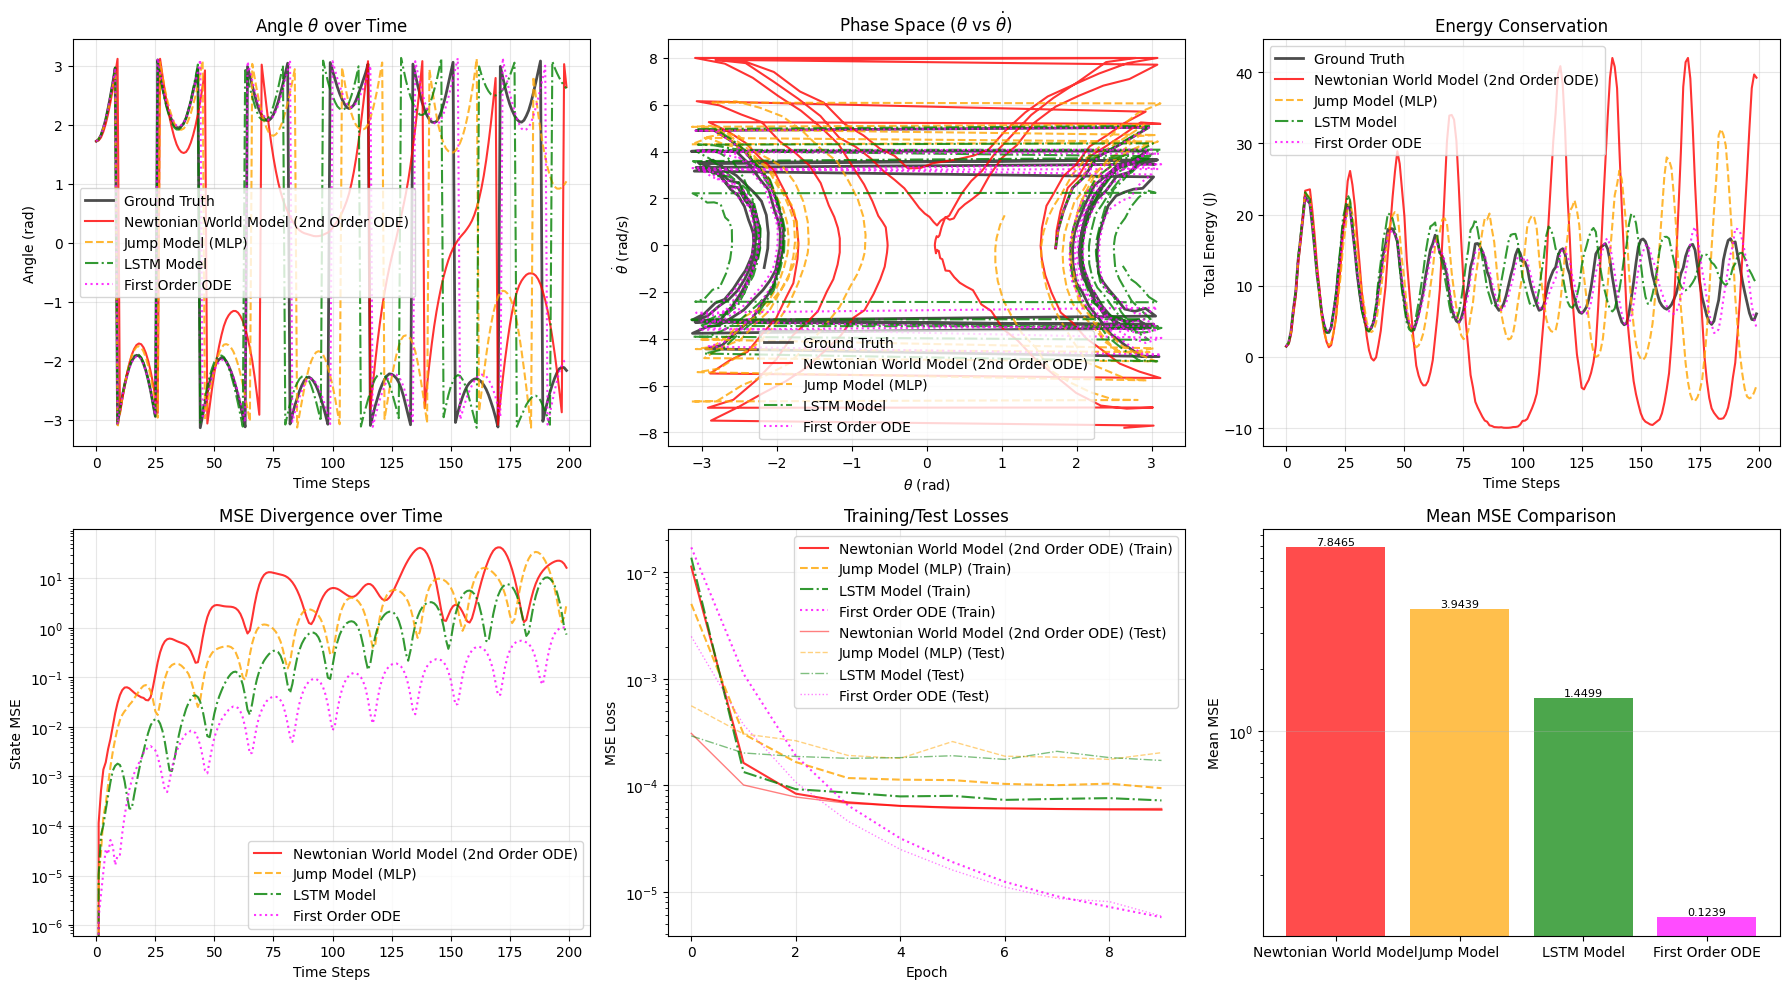


EVALUATION METRICS SUMMARY

Newtonian World Model (2nd Order ODE):
  Mean MSE:     7.846543
  Final MSE:    16.230328
  Energy Mean:  8.298578
  Energy Std:   15.290036

Jump Model (MLP):
  Mean MSE:     3.943948
  Final MSE:    2.941172
  Energy Mean:  10.429763
  Energy Std:   8.829865

LSTM Model:
  Mean MSE:     1.449894
  Final MSE:    0.726193
  Energy Mean:  12.107735
  Energy Std:   4.785629

First Order ODE:
  Mean MSE:     0.123944
  Final MSE:    0.993460
  Energy Mean:  10.757798
  Energy Std:   4.605036


In [48]:
# Collect data
dataset = PendulumDataset(n_seqs=500, seq_len=50)

# Train and evaluate all models
results = train_and_evaluate_all_models(
    dataset=dataset,
    epochs=10,
    batch_size=32,
    lr=1e-3,
    eval_horizon=200,
    verbose=True,
)

# Visualize comparison
visualize_model_comparison(results)

In [49]:
dt_results = evaluate_dt_generalization(results["models"])


Testing at dt=0.010...

Testing at dt=0.025...

Testing at dt=0.050...

Testing at dt=0.100...

Testing at dt=0.200...


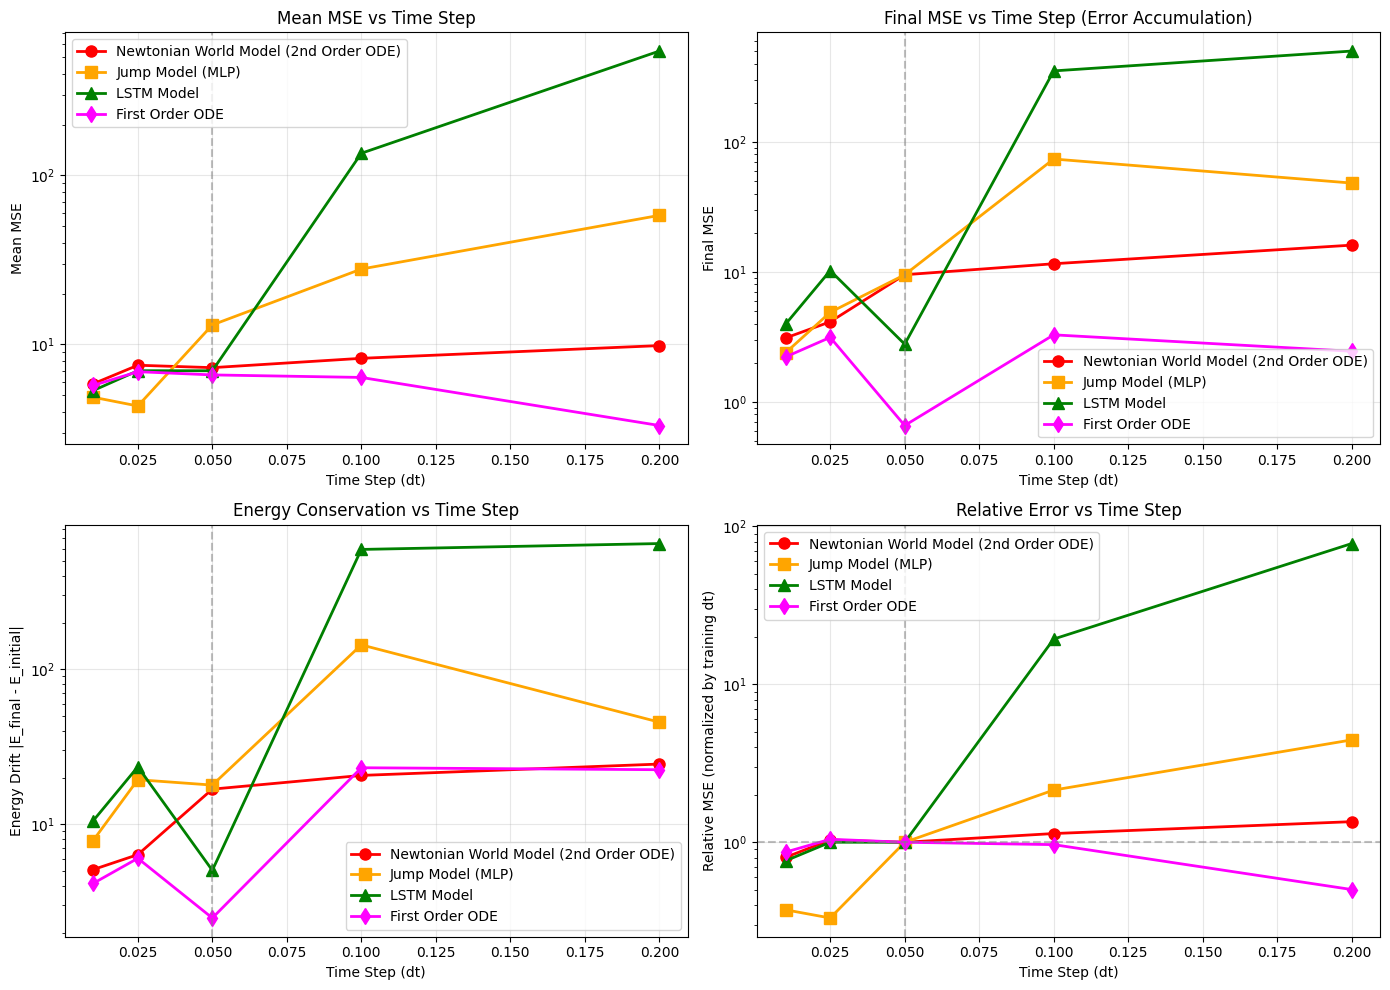


DT GENERALIZATION RESULTS
Model                          dt       Mean MSE     Final MSE    Energy Drift   
--------------------------------------------------------------------------------
Newtonian World Model (2nd Order ODE) 0.010    5.846978     3.099719     5.108315       
Jump Model (MLP)               0.010    4.871927     2.383346     7.869668       
LSTM Model                     0.010    5.329680     3.955274     10.546935      
First Order ODE                0.010    5.718253     2.215365     4.160896       
Newtonian World Model (2nd Order ODE) 0.025    7.531785     4.130920     6.382792       
Jump Model (MLP)               0.025    4.322786     4.884804     19.425711      
LSTM Model                     0.025    6.990537     10.223661    23.530738      
First Order ODE                0.025    6.897020     3.134878     6.043038       
Newtonian World Model (2nd Order ODE) 0.050    7.287022     9.502390     16.884313      
Jump Model (MLP)               0.050    13.041854  

In [50]:
visualize_dt_generalization(dt_results)